## SDSS-ALFALFA Photometry Check ##

The goal of this notebook is to identify galaxies that are in ALFALFA but have unreliable SDSS photometry.  

I am using Martha's catalogs that have cross-matched ALFALFA with SDSS.

### Loading python modules ###

starting with required python modules

In [19]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#from astropy.cosmology.funcs import distmod
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
from astropy import units as u
import warnings 
warnings.filterwarnings('ignore')


### Defining input file paths and filenames  ###

In [26]:
table_path = '/Users/rfinn/Dropbox/Research/APPSS/SDSSphot/run_sep14/'
latest_run = 'a100.code12.SDSSvalues170914.csv'
agc_cross = 'a100.sdsscross.code12.170914.csv'
HI = 'a100.code12.tab1.170914.csv'


### Reading in SDSS phot catalogs ###

In [27]:
infile = table_path+latest_run
sdss = np.recfromcsv(infile)
agc = np.recfromcsv(table_path+agc_cross)
HI = np.recfromcsv(table_path+HI)

In [16]:
print "AGC FIELDS: "
print agc.dtype.names

AGC FIELDS: 
('agcnum', 'hisrc', 'radeg', 'decdeg', 'icode', 'pcode', 'photoid', 'spectid', 'sdss_z')


In [17]:
print "SDSS FIELDS: "
print sdss.dtype.names

SDSS FIELDS: 
('agc', 'objid', 'parentid', 'specobjid', 'ra', 'dec', 'modelmag_u', 'modelmag_g', 'modelmag_r', 'modelmag_i', 'modelmag_z', 'modelmagerr_u', 'modelmagerr_g', 'modelmagerr_r', 'modelmagerr_i', 'modelmagerr_z', 'cmodelmag_u', 'cmodelmag_g', 'cmodelmag_r', 'cmodelmag_i', 'cmodelmag_z', 'cmodelmagerr_u', 'cmodelmagerr_g', 'cmodelmagerr_r', 'cmodelmagerr_i', 'cmodelmagerr_z', 'petromag_u', 'petromag_g', 'petromag_r', 'petromag_i', 'petromag_z', 'petromagerr_u', 'petromagerr_g', 'petromagerr_r', 'petromagerr_i', 'petromagerr_z', 'petrorad_u', 'petrorad_g', 'petrorad_r', 'petrorad_i', 'petrorad_z', 'petror50_g', 'petror50_r', 'petror50_i', 'petror90_g', 'petror90_r', 'petror90_i', 'extinction_u', 'extinction_g', 'extinction_r', 'extinction_i', 'extinction_z', 'expab_g', 'expab_r', 'expab_i', 'expmag_g', 'expmag_r', 'expmag_i', 'flags_u', 'flags_g', 'flags_r', 'flags_i', 'flags_z', 'flags', 'lnlexp_r', 'lnldev_r', 'type', 'fracdev_g', 'fracdev_r', 'fracdev_i', 'exprad_g', 'expra

In [28]:
print HI.dtype.names

('agcnr', 'name', 'radeg_hi', 'decdeg_hi', 'radeg_oc', 'decdeg_oc', 'vhelio', 'w50', 'errw50', 'hiflux', 'errflux', 'snr', 'rms', 'dist', 'logmsun', 'hicode')


### Calculate Distances to Galaxies ###

* Use SDSS optical redshift and Hubble's Law to get a distance 
in Mpc.  

* Calculate distance modulus (no extinction correction applied yet).

In [20]:
dist = agc['sdss_z']*c.to('km/s')/cosmo.H(0)
distmod = 5*np.log10(dist*1.e6/u.Mpc)-5


## Color-Magnitude Diagram ##

First thought is to look for outliers in the color-magnitude diagram.  Need to plot color vs absolute mag.  using sdss_z from agc catalog to calculate distance.

Looking for fits to red sequence of SDSS

* Blanton+2006: 
    * http://adsabs.harvard.edu/abs/2006ApJ...648..268B
    * http://iopscience.iop.org/article/10.1086/505628/fulltext/
    
    * converts mags to $^{0.1}u$ etc
    
        * $^{0.1}u = u + 0.33 + 0.32[(u-g) = 1.26]$
        * $^{0.1}g = g + 0.32 + 0.25[(u-g) = 1.26]$
    * fits to color-mag relations
        * $^{0.1}u > 1.5 $: $a_0 = 1.72$, $a_1 = -0.06$
        * $^{0.1}u < 1.5 $: $a_0 = 1.16$, $a_1 = -0.13$
    
    

In [42]:
def plot_redsequence():
    xl = np.linspace(-10,-25,20)
    yl = 1.72-0.06*xl
    plt.plot(xl,yl,'r-',lw=2)
def plot_bluesequence():
    xl = np.linspace(-10,-25,20)
    yl = 1.16-0.13*xl
    plt.plot(xl,yl,'b-',lw=2)
def plot_lines():
    plot_redsequence()
    plot_bluesequence()
    
def plotcolorabsmag():
    color = sdss['modelmag_g'] - sdss['modelmag_r']
    absmag = sdss['petromag_r'] - distmod
    plt.figure()
    plt.scatter(absmag,color,s=10,c=sdss['petror90_r'],vmin=0,vmax=20,edgecolors='face')
    #plt.hexbin(absmag,color)
    cb = plt.colorbar(label='Petro_R90(r)')
    plt.xlabel('$M_r$',fontsize=16)
    plt.ylabel('$(g - r)_{model}$',fontsize=16)
    #plot_redsequence()
    #plot_bluesequence()
def plotcolorabsmag_hexbin():
    plt.figure()
    mylimits = [-25,-15,.5,2]
    plt.hexbin(absmag,color,extent=mylimits)
    plot_redsequence()
    plot_bluesequence()
    plt.axis(mylimits)
    plt.gca().invert_xaxis()
    plt.xlabel('$M_r$',fontsize=16)
    plt.ylabel('$(u - g)_{model}$',fontsize=16)
    


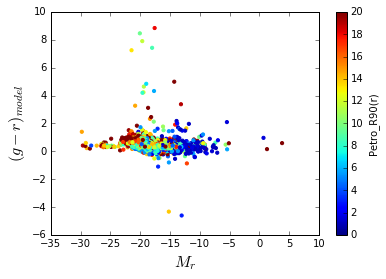

In [43]:
plotcolorabsmag()


### Looking at Size-Magnitude Relation ###

What size to use?

* Petrosian 50
* Petrosian 90
* exponential radius

In [66]:
def plotabsmagsize():
    size = sdss['exprad_r'] 
    absmag = sdss['petromag_r'] - distmod
    plt.figure()
    plt.scatter(absmag,size,s=10,c=sdss['expab_r'],vmin=0,vmax=1,edgecolors='face',alpha=0.2)
    #plt.hexbin(absmag,color)
    cb = plt.colorbar(label='expab_r')
    plt.xlabel('$M_r$',fontsize=16)
    plt.ylabel('$exp-rad-r$',fontsize=16)
    plt.gca().set_yscale('log')
    plt.ylim(.0001,100)

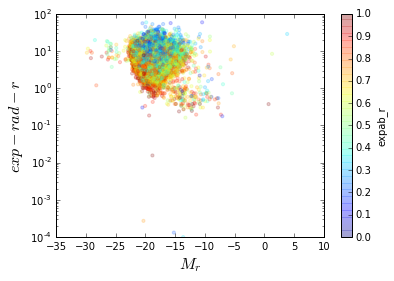

In [67]:
plotabsmagsize()

### Which magnitude to use? ###

From http://www.sdss.org/dr12/algorithms/magnitudes/#mag_petro

* #### Photometry of Nearby Galaxies: 
Galaxies bright enough to be included in our spectroscopic sample have relatively high signal-to-noise ratio measurements of their Petrosian magnitudes. Since these magnitudes are model-independent and yield a large fraction of the total flux, roughly constant with redshift, petroMag is the measurement of choice for such objects. In fact, the noise properties of Petrosian magnitudes remain good to r=20 or so.
* #### Photometry of Galaxies: 
Under most conditions, the cmodel magnitude is now a reliable estimate of the galaxy flux. In addition, this magnitude account for the effects of local seeing and thus are less dependent on local seeing variations.
* #### Colors of Galaxies: 
For measuring colors of extended objects, we continue to recommend using the model (not the cmodel) magnitudes. The model magnitude is calculated using the best-fit parameters in the r band, and applies it to all other bands; the light is therefore measured consistently through the same aperture in all bands.

### What do the flags tell us? ###

http://www.sdss3.org/dr8/algorithms/photo_flags_recommend.php

http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=search+flags